# ATMS 523 - Final Project
# Analyzing the effect of ENSO, PDO, and NAO on Winter Precipitation Anomalies in the Western Himalayas (Northern India/Pakistan & Western China)


2) ERA5 Reanalysis (Monthly Mean 0.25 Degree Latitude-Longitude Grid) DOI: 10.5065/P8GT-0R61
3) ENSO Data Source: https://psl.noaa.gov/data/timeseries/monthly/oni/ 
4) PDO Data Source: https://www.ncei.noaa.gov/access/monitoring/pdo/  
5) NAO Data Source: https://www.ncei.noaa.gov/access/monitoring/nao/




Introduction:

- Western Disturbances are extratropical cyclones that strike Northern India/Pakistan & Western China in the fall/winter/early spring months. It is an important source of snowfall for the Himalayas, and precipitation at lower elevations helps develop wheat and apple crops. Years with weak and infrequent Western Disturbances can cause severe drought which interferes with the ecosystem, tourism and agriculture. 

- Researchers have investigated the role of various climate patterns on winter precipitation in the aforementioned Himalayan region. Studies have indicated that ENSO (El-Nino Southern Oscillation), NAO (North Atlantic Oscillation), and the PDO (Pacific Decadal Oscillation) have impacts upon these precipitation trends. I want to vet whether we can use these trends to predict how much monthly fall/winter precipitation will deviate from the average. I will use two different methods to accomplish this. First, I will use multivariate linear regression to predict monthly (Oct-Apr) precipitation anomalies from the monthly 1979-2022 averages using these 3 climate features. I will then use a random forest regression model to calculate the same thing. I will also explore whether one hot encoding the month as an additional feature will help improve the model.

The region I am performing the analysis on is a rectangular grid with the dimensions 70-80 deg E longitude, 30-37 deg N latitude. 



In [2]:
#Import necessary modules 

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Let's pull in the ERA5 monthly mean data! 

In [3]:
base_url = 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'


pr = pd.date_range(start='1979-01',end='2022-12', freq='AS')

file_list=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list.append(single_file)

In [4]:
file_list

['https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc',
 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1980/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1980010100_1980120100.nc',
 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1981/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1981010100_1981120100.nc',
 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1982/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1982010100_1982120100.nc',
 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1983/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1983010100_1983120100.nc',
 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1984/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1984010100_1984120100.nc',
 'https://thredds.rda.ucar.edu/thredds/dodsC/f

In [5]:
ds = xr.open_mfdataset(file_list)

In [6]:
# Aggregated mean monthly total daily precip values for the region of interest from 1979-2022

# Lat/lon box with center and size specified
lon_min = 70
lon_max = 80
lat_min = 30
lat_max = 37

#Select Data in chosen region in Fall/Winter months (October-April) from 1979-2023

box_ds_raw = ds.sel(

    time=(ds['time'].dt.year >= 1979) &
    (ds['time'].dt.year <= 2023) & (ds['time'].dt.month >= 10) | (ds['time'].dt.month <= 4),

    longitude=slice(lon_min, lon_max),
    latitude=slice(lat_max,lat_min)
)

# Monthly Mean precipitation in box (temporal)
box_ds = box_ds_raw.mean(dim=['longitude', 'latitude'])

box_ds['days_per_month'] = box_ds['time'].dt.days_in_month

monthly_precip = box_ds['days_per_month']*box_ds['TP']

monthly_precip_df =  monthly_precip.to_series()

monthly_precip_df.index.name = 'Date'
monthly_precip_df.name = 'Monthly_Precip_m'

monthly_precip_df.head(10)

Date
1979-01-01    0.048860
1979-02-01    0.073786
1979-03-01    0.115423
1979-04-01    0.060612
1979-10-01    0.016164
1979-11-01    0.029128
1979-12-01    0.039955
1980-01-01    0.046055
1980-02-01    0.080858
1980-03-01    0.091472
Name: Monthly_Precip_m, dtype: float64

In [7]:
monthly_averages = monthly_precip.groupby('time.month').mean('time')

print(monthly_averages.values)


[0.05247256 0.07249026 0.08648205 0.06460846 0.02893203 0.02633539
 0.03606922]


In [8]:
# Import in oni (Ocean Nino Index) Data 
# Source: https://psl.noaa.gov/data/timeseries/monthly/oni/ 
oni = pd.read_csv('oni.csv')

# Melt the DataFrame
oni_melted = oni.melt(id_vars=['Year'], var_name='Month', value_name='Value')

# Drop rows where either 'Year' or 'Value' might be NaN
oni_melted.dropna(subset=['Year', 'Value'], inplace=True)

# Ensure the 'Year' and 'Month' are integers (or at least non-null strings)
oni_melted['Year'] = oni_melted['Year'].astype(int)
oni_melted['Month'] = oni_melted['Month'].astype(str)  # Zero-pad the month

# Create a 'Date' column safely
try:
    oni_melted['Date'] = pd.to_datetime(oni_melted['Year'].astype(str) + '-' + oni_melted['Month'])
except ValueError as e:
    print(f"Error converting to datetime: {e}")
    # You might want to handle the error in a specific way here

# Drop unnecessary columns and reorder
oni_final = oni_melted.drop(columns=['Year', 'Month'])
oni_final = oni_final[['Date', 'Value']]


oni = oni_final

oni.head(10)


,Date,Value
0,1950-01-01,-1.53
1,1951-01-01,-0.82
2,1952-01-01,0.53
3,1953-01-01,0.40
4,1954-01-01,0.76
5,1955-01-01,-0.68
6,1956-01-01,-1.11
7,1957-01-01,-0.25
8,1958-01-01,1.81
9,1959-01-01,0.61


In [9]:
#Import Pacific Decadal Oscillation Data (PDO)
#Source: https://www.ncei.noaa.gov/access/monitoring/pdo/ 

# Load the data from a CSV file into a DataFrame
pdo = pd.read_csv('pdo.csv')

# Melt the DataFrame
pdo_melted = pdo.melt(id_vars=['Year'], var_name='Month', value_name='Value')

# Drop rows where either 'Year' or 'Value' might be NaN
pdo_melted.dropna(subset=['Year', 'Value'], inplace=True)

# Ensure the 'Year' and 'Month' are integers (or at least non-null strings)
pdo_melted['Year'] = pdo_melted['Year'].astype(int)
pdo_melted['Month'] = pdo_melted['Month'].astype(str)  # Zero-pad the month

# Create a 'Date' column safely
try:
    pdo_melted['Date'] = pd.to_datetime(pdo_melted['Year'].astype(str) + '-' + pdo_melted['Month'])
except ValueError as e:
    print(f"Error converting to datetime: {e}")

# Drop unnecessary columns and reorder
pdo_final = pdo_melted.drop(columns=['Year', 'Month'])
pdo_final = pdo_final[['Date', 'Value']]

# Replace the original DataFrame with the final, processed DataFrame
pdo = pdo_final

# Display the first 10 rows of the final DataFrame
pdo.head(10)

,Date,Value
0,1854-01-01,0.11
1,1855-01-01,-0.20
2,1856-01-01,-0.39
3,1857-01-01,-0.52
4,1858-01-01,-0.96
5,1859-01-01,-1.22
6,1860-01-01,-1.31
7,1861-01-01,-0.57
8,1862-01-01,-0.41
9,1863-01-01,-0.06


In [10]:
#Read in NAO Data (North atlantic oscillation)
#Source: https://www.ncei.noaa.gov/access/monitoring/nao/

# Load the data from a CSV file into a DataFrame
nao = pd.read_csv('nao.csv')

# Melt the DataFrame
nao_melted = nao.melt(id_vars=['Year'], var_name='Month', value_name='Value')

# Drop rows where either 'Year' or 'Value' might be NaN
nao_melted.dropna(subset=['Year', 'Value'], inplace=True)

# Ensure the 'Year' and 'Month' are integers (or at least non-null strings)
nao_melted['Year'] = nao_melted['Year'].astype(int)
nao_melted['Month'] = nao_melted['Month'].astype(str)  # Zero-pad the month

# Create a 'Date' column safely
try:
    nao_melted['Date'] = pd.to_datetime(nao_melted['Year'].astype(str) + '-' + nao_melted['Month'])
except ValueError as e:
    print(f"Error converting to datetime: {e}")

# Drop unnecessary columns and reorder
nao_final = nao_melted.drop(columns=['Year', 'Month'])
nao_final = nao_final[['Date', 'Value']]

# Replace the original DataFrame with the final, processed DataFrame
nao = nao_final

# Display the first 10 rows of the final DataFrame
nao.head(10)

,Date,Value
0,1950-01-01,0.92
1,1951-01-01,0.08
2,1952-01-01,0.93
3,1953-01-01,0.33
4,1954-01-01,0.37
5,1955-01-01,-1.84
6,1956-01-01,-0.22
7,1957-01-01,1.05
8,1958-01-01,-0.54
9,1959-01-01,-0.87


In [11]:
# Merge above datasets together - only consider data from 1979-2022 

df_temp = pd.merge(oni,nao,on='Date',suffixes=('_ONI', '_NAO'))

df_temp_2 = pd.merge(df_temp,pdo,on='Date')

df_temp_2.rename(columns={'Value': 'Value_PDO'}, inplace=True)

#Merge monthly precip data with the indices 

monthly_precip_df.head(10)

df_temp_3 = pd.merge(df_temp_2,monthly_precip_df,on='Date')

df_temp_3.tail(10)




,Date,Value_ONI,Value_NAO,Value_PDO,Monthly_Precip_m
298,2013-12-01,-0.27,0.95,-1.04,0.025812
299,2014-12-01,0.66,1.86,1.86,0.017567
300,2015-12-01,2.64,2.24,0.29,0.029389
301,2016-12-01,-0.56,0.48,0.61,0.013456
302,2017-12-01,-0.97,0.88,-0.03,0.038353
303,2018-12-01,0.81,0.61,-0.21,0.016868
304,2019-12-01,0.55,1.20,0.00,0.031687
305,2020-12-01,-1.19,-0.30,-0.99,0.037528
306,2021-12-01,-0.98,0.29,-2.71,0.019194
307,2022-12-01,-0.83,-0.15,-2.21,0.016745


In [12]:
#Add column with precipitation anomalies from 1979-2022 average (for each month)

monthly_averages = [0.05247256,0.07249026,0.08648205,0.06460846,0.02893203,0.02633539, 0.03606922]

# Example dictionary of monthly averages (for all months)
monthly_average = {'October':monthly_averages[4] , 'November': monthly_averages[5], 'December': monthly_averages[6],'January': monthly_averages[0], 'February': monthly_averages[1], 'March': monthly_averages[2],'April':monthly_averages[3]}
                    
# Map these averages to each row based on the month
df_temp_3['Monthly_Avg_Precip_m'] = df_temp_3['Date'].dt.month_name().map(monthly_average)


# Calculate departure

df_temp_3['Precip_Departure_m'] = df_temp_3['Monthly_Precip_m'] - df_temp_3['Monthly_Avg_Precip_m']

df_temp_3.head(10)

df = df_temp_3

df.head(50)
# # View the modified DataFrame

,Date,Value_ONI,Value_NAO,Value_PDO,Monthly_Precip_m,Monthly_Avg_Precip_m,Precip_Departure_m
0,1979-01-01,0.03,-1.38,-0.38,0.048860,0.052473,-0.003613
1,1980-01-01,0.59,-0.75,0.06,0.046055,0.052473,-0.006418
2,1981-01-01,-0.26,0.37,1.18,0.066008,0.052473,0.013535
3,1982-01-01,-0.05,-0.89,0.11,0.060895,0.052473,0.008422
4,1983-01-01,2.18,1.59,0.40,0.057746,0.052473,0.005273
5,1984-01-01,-0.60,1.66,1.42,0.030086,0.052473,-0.022387
6,1985-01-01,-1.04,-1.61,0.87,0.049016,0.052473,-0.003457
7,1986-01-01,-0.49,1.11,1.04,0.014603,0.052473,-0.037870
8,1987-01-01,1.23,-1.15,1.47,0.020007,0.052473,-0.032465
9,1988-01-01,0.81,1.02,0.23,0.047813,0.052473,-0.004659


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


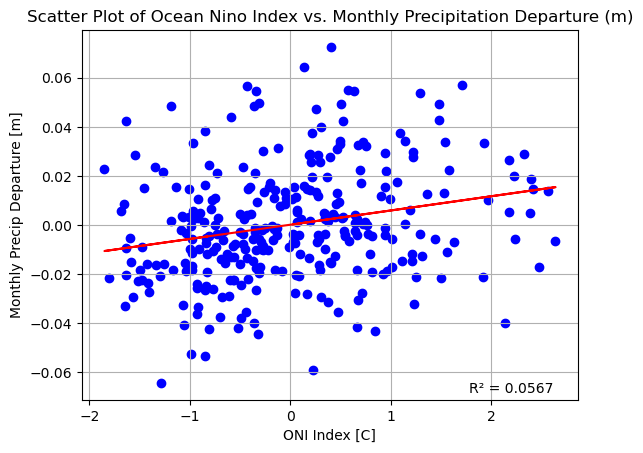

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


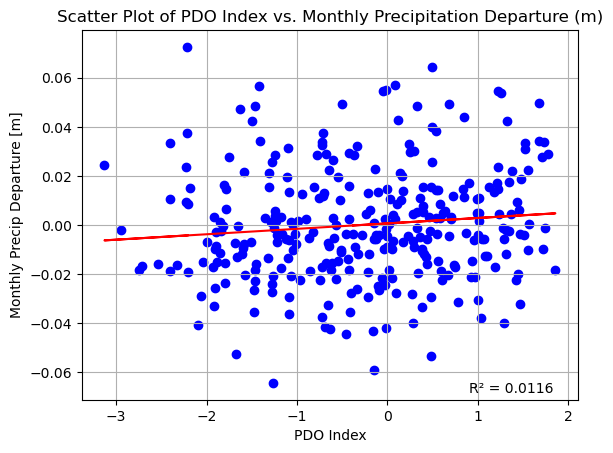

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


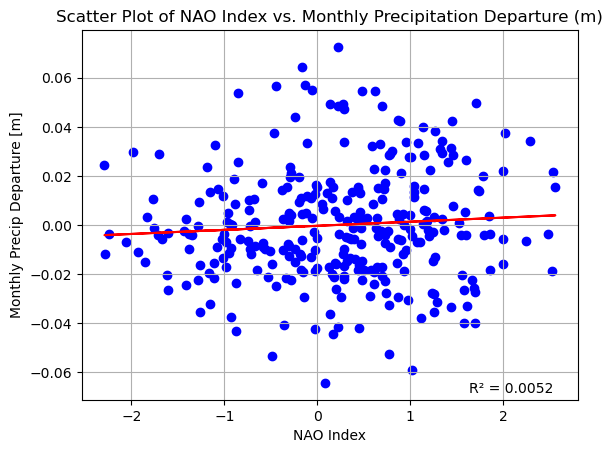

In [13]:
#Perform a linear regression on monthly precip anomalies vs. each of the three climate features (ENSO, NAO, PDO)

coefficients = np.polyfit(df['Value_ONI'], df['Precip_Departure_m'], 1)  # Linear fit
polynomial = np.poly1d(coefficients)
y_fit = polynomial(df['Value_ONI'])

correlation_matrix = np.corrcoef(df['Precip_Departure_m'], y_fit)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

plt.plot(df['Value_ONI'], y_fit, color='red', label='Line of Best Fit')
plt.scatter(df['Value_ONI'], df['Precip_Departure_m'],color='blue',label='Data Points')
plt.text(0.95, 0.01, f'R² = {r_squared:.4f}', ha='right', va='bottom', transform=plt.gca().transAxes)
plt.title('Scatter Plot of Ocean Nino Index vs. Monthly Precipitation Departure (m)')
plt.xlabel('ONI Index [C]')
plt.ylabel('Monthly Precip Departure [m]')
plt.grid(True)
plt.show()


coefficients = np.polyfit(df['Value_PDO'], df['Precip_Departure_m'], 1)  # Linear fit
polynomial = np.poly1d(coefficients)
y_fit = polynomial(df['Value_PDO'])

correlation_matrix = np.corrcoef(df['Precip_Departure_m'], y_fit)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

plt.plot(df['Value_PDO'], y_fit, color='red', label='Line of Best Fit')
plt.scatter(df['Value_PDO'], df['Precip_Departure_m'],color='blue',label='Data Points')
plt.text(0.95, 0.01, f'R² = {r_squared:.4f}', ha='right', va='bottom', transform=plt.gca().transAxes)
plt.title('Scatter Plot of PDO Index vs. Monthly Precipitation Departure (m)')
plt.xlabel('PDO Index')
plt.ylabel('Monthly Precip Departure [m]')
plt.grid(True)
plt.show()

coefficients = np.polyfit(df['Value_NAO'], df['Precip_Departure_m'], 1)  # Linear fit
polynomial = np.poly1d(coefficients)
y_fit = polynomial(df['Value_NAO'])

correlation_matrix = np.corrcoef(df['Precip_Departure_m'], y_fit)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

plt.plot(df['Value_NAO'], y_fit, color='red', label='Line of Best Fit')
plt.scatter(df['Value_NAO'], df['Precip_Departure_m'],color='blue',label='Data Points')
plt.text(0.95, 0.01, f'R² = {r_squared:.4f}', ha='right', va='bottom', transform=plt.gca().transAxes)
plt.title('Scatter Plot of NAO Index vs. Monthly Precipitation Departure (m)')
plt.xlabel('NAO Index')
plt.ylabel('Monthly Precip Departure [m]')
plt.grid(True)
plt.show()




Two major takeaways. One - there is A LOT of variance, so there are no strong trends (low R^2). However, there does seem to be an increase in monthly precipitation for increasing PDO and especially NAO indexes. Let's now do a multivariate linear regression (combining all three above features) to predict monthly precipitation anomalies from the 1979-2022 average. 

In [14]:
#Perform multivariate linear regression
# X values: ENSO Index, NAO Index, PDO Index

# Selecting the first two columns as features and the third as the target
X = df[['Value_ONI', 'Value_PDO', 'Value_NAO']]
y = df['Precip_Departure_m']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a pipeline with standardization and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('regressor', LinearRegression())  # Regression model
])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting using the pipeline
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Calculating the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can access model coefficients via
print('Coefficients:', pipeline.named_steps['regressor'].coef_)
print('Intercept:', pipeline.named_steps['regressor'].intercept_)

# Calculate adjusted R^2
n = X_test.shape[0]  # Number of observations in the test set
p = X_test.shape[1]  # Number of features (predictors)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Adjusted R^2 Score: {adjusted_r2}')



Mean Squared Error: 0.00045078258405305337
Coefficients: [0.00436527 0.0009681  0.00222828]
Intercept: -0.000580704751781626
Adjusted R^2 Score: 0.028126651787166557


This is a terrible R^2 value! Let's do one hot encoding of the given month (Oct-Apr) to see if that extra information improves the regression. 

In [15]:
# One hot encoding of month and attempt linear regression again
df['mo'] = df['Date'].dt.month

df_onehot = pd.get_dummies(df, columns=['mo'],dtype='int')

# Selecting the first two columns as features and the third as the target
X = df_onehot[['Value_ONI', 'Value_PDO', 'Value_NAO','mo_1','mo_2','mo_3','mo_4','mo_10','mo_11','mo_12']]
y = df_onehot['Precip_Departure_m']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Creating a pipeline with standardization and linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('regressor', LinearRegression())  # Regression model
])

# Fitting the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predicting using the pipeline
y_pred = pipeline.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Calculating the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can access model coefficients via
print('Coefficients:', pipeline.named_steps['regressor'].coef_)
print('Intercept:', pipeline.named_steps['regressor'].intercept_)

# Calculate adjusted R^2
n = X_test.shape[0]  # Number of observations in the test set
p = X_test.shape[1]  # Number of features (predictors)
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Adjusted R^2 Score: {adjusted_r2}')


Mean Squared Error: 0.0005195396787543509
Coefficients: [4.29119916e-03 9.34692100e-04 3.09789594e-03 1.94521907e+12
 1.86371105e+12 1.94521907e+12 1.89162146e+12 1.94521907e+12
 1.94521907e+12 2.02049373e+12]
Intercept: -0.00018749048394582743
Adjusted R^2 Score: -0.21573080020809154


Wow! The linear regression is now even worse (negative R^2 value). We need to reassess whether a linear regression is the way to go. Let's repeat this with a random forest regression model to see if we get a better R^2 value. 

In [16]:
#Random forest model 

from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest Regressor and grid search parameters
rf = RandomForestRegressor(random_state=42)
param_grid = {
'bootstrap': [True],
'max_depth': [100,200,300],
'max_features': ['auto'],
'min_samples_leaf': [4],
'min_samples_split': [10],
'n_estimators': [3000,4000,5000]} 

from sklearn.model_selection import GridSearchCV

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid)

# Perform the grid search
grid_search.fit(X_train, y_train)


# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_train)
mse = mean_squared_error(y_train, predictions)

print("Mean Squared Error of the best model: ", mse)

r2 = r2_score(y_train, predictions)
print(f'R2 of best model = {r2}')

/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/sunnysharma/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this param

Best parameters found:  {'bootstrap': True, 'max_depth': 100, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 3000}
Mean Squared Error of the best model:  0.0002913873430654508
R2 of best model = 0.4771972016346917


Wow! The random forest regression model performs much better (R^2=0.477), the data must be inherently nonlinear and is teasing out relationships that a linear regression cannot capture

Let's now do a feature importance to see which features are the most important. 

mo_10        0.004986
mo_4         0.007116
mo_11        0.007667
mo_12        0.011017
mo_2         0.027099
mo_1         0.034215
mo_3         0.083799
Value_NAO    0.207951
Value_PDO    0.275461
Value_ONI    0.340690
dtype: float64
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNI

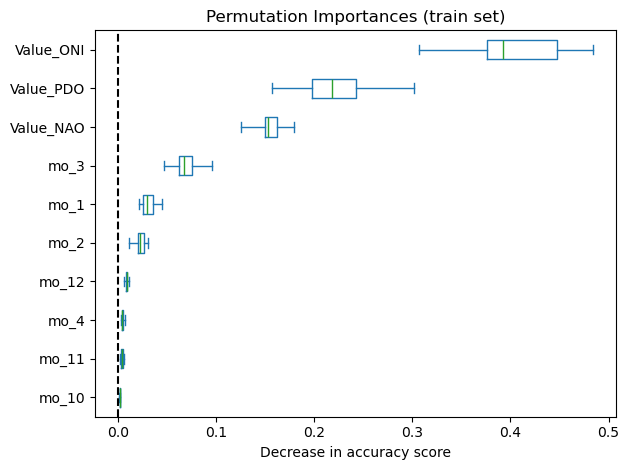

In [17]:
# 5. Perform a feature importance and multipass permutation analysis of your features.


from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance

features_df = df_onehot[['Value_ONI', 'Value_PDO', 'Value_NAO','mo_1','mo_2','mo_3','mo_4','mo_10','mo_11','mo_12']]

# Get the feature names excluding the target
feature_names= features_df.columns.tolist()


mdi_importances = pd.Series(
     best_model.feature_importances_, index=feature_names
  ).sort_values(ascending=True)


# FEATURE IMPORTANCE 
print(mdi_importances)


#MULTIPASS PERUMTATION 
result = permutation_importance(
    best_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=features_df.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()


As expected (from our earlier univariate linear regression analysis), ONI is the most important feature, followed by PDO and then NAO. One hot encoding the months does not seem to have improved the model much (except for maybe month 3)